### Introduction


**Probelm Statement:** Make a classifier which takes in a job description and gives the department name for it.
*   Use a neural network model
*   Make use of a pre-trained Word Embeddings (example: Word2Vec, GloVe, etc.)
*   Calculate the accuracy on a test set (data not used to train the model)

**Problem Solving Approach:** 
_Provide a brief description of steps you followed for solving this problem_
1. Check dataset and visulize labels to find balanced or unbalanced
2. If Unbalanced, do upsampling and downsampling accordingly
3. Fit model with linear classifiers and estimate accuracy and confusion matrix
4. Fit model with Neural Network classifiers and estimate accuracy and confusion matrix
5. Use Pre-trained word embedding and fit model with Neural Network classifiers and estimate accuracy and confusion matrix

## Importing Libraries

In [162]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [163]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, accuracy_score
import seaborn as sn

## Defining hot encoding and decoding Functions

In [164]:
def hotencode(arr):
    a = np.zeros([len(arr), np.max(arr)])
    for i in range(len(arr)):
        col = arr[i]
        a[i,col-1] = 1
    return a
    # invert first example
    # inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
    # print(inverted)

def hotdecode(arr):
    a = []
    for i in range(len(arr)):
        a.append(np.argmax(arr[i,:])+1)
    return np.asarray(a)

## Part 1 - Loading dataset and Text Preprocessing
_Include all text preprocesing steps like processing of json,csv files & data cleaning in this part._

In [4]:
path_json = 'C:/Users/Dolpy/Desktop/mohitatbb-machine-learning-assessment-2ef59f0cd1ce/data/docs'
path_csv = 'C:/Users/Dolpy/Desktop/mohitatbb-machine-learning-assessment-2ef59f0cd1ce/data'
file_csv = os.path.join(path_csv, 'document_departments.csv')

In [5]:
# Loading csv files
data = pd.read_csv(file_csv)
data.head(5)

,Document ID,Department
0,8196431,Customer service
1,8278123,Digital Marketing
2,8331625,Sales
3,8331003,Back office ticketing
4,8277939,Digital Marketing


In [6]:
# Total number of datapoints
print('Total number of dataset available %d'%(len(data)))

Total number of dataset available 1162


In [7]:
# Loading Json object for readability
obj = json.load(open(os.path.join(path_json, str(data['Document ID'][78]) + '.json')))
obj

{'company_info': {'Company Description': "cmts is engaged in the data entry outsourcing and supply of skilled/semi skilled &amp; unskilled Manpower across the industry spectrum. Our pool of manpower ranges from professionals such as Sales &amp; technical professionals in different categories, IT professionals, aviation sector, technical profiles, engineers, non-technical in-house professionals, administrative profiles, Accountant, HR, Back office, Data Entry Operator etc. Our organization's goal is total clients satisfaction through quality and personalized delivery of each and every service. We therefore exist to cater the need of these prospecting employers/companies since our inception in 2008.",
  'Email': 'hr@cmts.in',
  'Company Name': 'CMTS (Core Management &amp; Technical Services)',
  'Telephone': '9631857963'},
 'api_data': {'job_location': ['Ludhiana'],
  'jd_id': '6600981',
  'job_keywords': ['Ticketing Executive for Tavel Company at Saanewal Ludhiana'],
  'job_industry': '

Useful Attributes
1. job_keywords
2. job_title
3. Skills
4. Department

In [8]:
# Number of Major attributes in JSON object
print('Number of attributes: %d'%(len(obj.keys())))

Number of attributes: 6


### Part II: Exploratoty Data Analysis

_Include EDA steps like finding distribution of Departments in this part, you may also use plots for EDA._

### Counting datapoints from different department

In [9]:
data['count'] = data['Department'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = data.groupby('Department').agg({'count': 'sum'}).reset_index()

In [10]:
unique_img_ids.head()

,Department,count
0,Administration,38
1,Airline Ground Operations,4
2,Analytics,9
3,Back office ticketing,18
4,Content,6


### Creating a Hashmap of Departments and labels

In [11]:
unique_img_ids['Department'].values

array(['Administration', 'Airline Ground Operations', 'Analytics',
       'Back office ticketing', 'Content', 'Customer service',
       'Data entry', 'Digital Marketing',
       'Engineering Design Construction', 'Finance', 'Flight Operations',
       'IT', 'Learning and Development ', 'Logistics', 'Maintenance',
       'Management Consulting', 'Marine Deck ', 'Marine Engineering ',
       'Marine Service Steward ', 'Marketing', 'Operations', 'Presales ',
       'Procurement', 'Public Relations ', 'QA ', 'Recruitment',
       'Safety ', 'Sales', 'Technology', 'Ticketing'], dtype=object)

In [12]:
depart_map = {}
for i in range(len(unique_img_ids)):
    depart_map[unique_img_ids['Department'][i]] = i+1

In [13]:
# Number of different departments
print('Number of departments: %d'%(len(unique_img_ids)))

Number of departments: 30


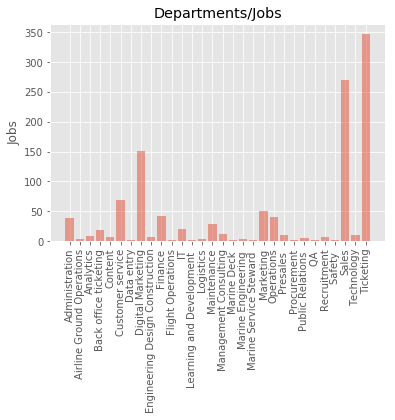

In [187]:
# Plotting number of jobs in different departments
y_pos = np.arange(len(unique_img_ids))
objects = unique_img_ids['Department']
performance = unique_img_ids['count']
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Jobs')
plt.title('Departments/Jobs')
plt.xticks(rotation=90)

plt.show()

### Selecting important atttributes
1. Department
2. JobTitle
3. JobKeywords

In [15]:
n = len(data)
label = []
keyword = []

In [16]:
# Creating a new dataframe for selected attributes only
for i in range(n):
    obj = json.load(open(os.path.join(path_json, str(data['Document ID'][i]) + '.json')))
    department = obj['other_details']['Department:']
    title = obj['api_data']['job_title']
    obj = obj['api_data']['job_keywords']
    
    st = [st.strip(' ') for st in obj]
    dp = [dp.strip(' ') for dp in department]
    tt = [tt.strip(' ') for tt in title]
    st = st + dp + tt
    
    str_join = ",".join(st)
    label.append(depart_map[data['Department'][i]])
    keyword.append(str_join)

### Creating a new dataframe from selected attributes and their respective labels

In [17]:
df = []
df = pd.DataFrame(label, columns=['label'])
df.head()

,label
0,6
1,8
2,28
3,4
4,8


In [18]:
df2 = pd.DataFrame(keyword, columns=['keyword'])
df2.head()

,keyword
0,"telesales,telemarketing,communication,call cen..."
1,"internet media,facebook marketing,online adver..."
2,"immigration,canada pr,australia pr,client serv..."
3,"documentation,,Back Office Operations,F,r,e,s,..."
4,"internet media,facebook marketing,online adver..."


In [19]:
df = df.merge(df2, left_index=True, right_index=True)
df.head()

,label,keyword
0,6,"telesales,telemarketing,communication,call cen..."
1,8,"internet media,facebook marketing,online adver..."
2,28,"immigration,canada pr,australia pr,client serv..."
3,4,"documentation,,Back Office Operations,F,r,e,s,..."
4,8,"internet media,facebook marketing,online adver..."


In [178]:
x = df['keyword'].values
y = df['label'].values

### Data Imbalance Situation
Here we can clearly see that data classes given are not uniform. This is dealt in the later section

In [177]:
df['label'].value_counts()

30    347
28    270
8     151
6      69
20     50
10     42
21     41
1      38
15     28
12     20
4      18
16     12
29     10
22     10
3       9
9       7
26      6
5       6
24      5
2       4
18      3
14      3
17      2
19      2
25      2
7       2
11      2
13      1
23      1
27      1
Name: label, dtype: int64

### Part III: Modelling & Evaluation

_Include all model prepration & evaluation steps in this part._

Spliting dataset into Training and Testing

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [23]:
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

size of x_train (871,), x_test (291,), y_train (871,), y_test (291,)


### Vectorization of words
Generating feature vector

In [24]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)
X_train

<871x1321 sparse matrix of type '<class 'numpy.int64'>'
	with 9306 stored elements in Compressed Sparse Row format>

Hotencoding of labels

In [25]:
y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)

## Number of Classifiers

### 1. Logistic Regression

In [26]:
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(X_train, y_train)
score = logistic.score(X_test, y_test)

print("Accuracy of Logistic classifier:", round(score,4)*100)

Accuracy of Logistic classifier: 90.72


### 2. Stochastic Gradient Descent

In [27]:
sgd = sklearn.linear_model.SGDClassifier(class_weight='balanced')
sgd.fit(X_train, y_train)
score = sgd.score(X_test, y_test)

print("Accuracy of sgd classifier:", round(score,4)*100)

Accuracy of sgd classifier: 87.63


### 3. Decision Tree

In [28]:
tree = DecisionTreeClassifier(class_weight='balanced')
tree.fit(X_train, y_train)
score = tree.score(X_test, y_test)

print("Accuracy of tree classifier:", round(score,4)*100)

Accuracy of tree classifier: 85.22


### 4. Random Forest

In [29]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
score = forest.score(X_test, y_test)

print("Accuracy of forest classifier:", round(score,4)*100)

Accuracy of forest classifier: 88.32


In [30]:
y_pred = forest.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

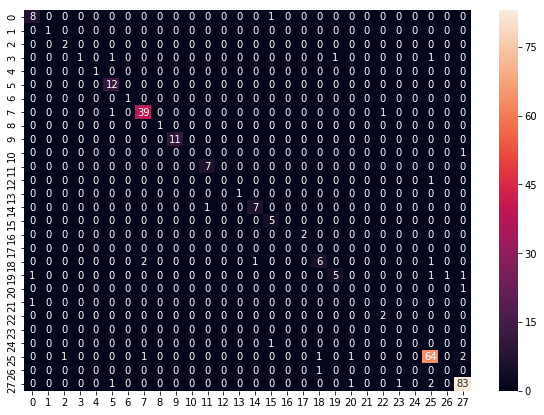

In [31]:
index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Here I can see a lot of miss classification of classes specifically for those which have very low class count. So we need to do data balancing first

### 5. Simple Neural Network

In [32]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))

Using TensorFlow backend.


In [33]:
model.compile(loss='categorical_crossentropy', 
                   optimizer='adam', 
                   metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                13220     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
Total params: 13,550
Trainable params: 13,550
Non-trainable params: 0
_________________________________________________________________


In [155]:
history = model.fit(X_train, y_train_hot,
                 epochs=100,
                 verbose=True,
                 validation_data=(X_test, y_test_hot),
                 batch_size=10)

Train on 375 samples, validate on 125 samples
Epoch 1/100
375/375 [==============================] - 0s 484us/step - loss: 0.0075 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9920
Epoch 2/100
375/375 [==============================] - 0s 441us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9920
Epoch 3/100
375/375 [==============================] - 0s 415us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9920
Epoch 4/100
375/375 [==============================] - 0s 423us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0167 - val_acc: 0.9920
Epoch 5/100
375/375 [==============================] - 0s 415us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 0.9920
Epoch 6/100
375/375 [==============================] - 0s 423us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9920
Epoch 7/100
375/375 [==============================] - 0s 471us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9920
Epoch 8/1

In [35]:
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8832


In [36]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


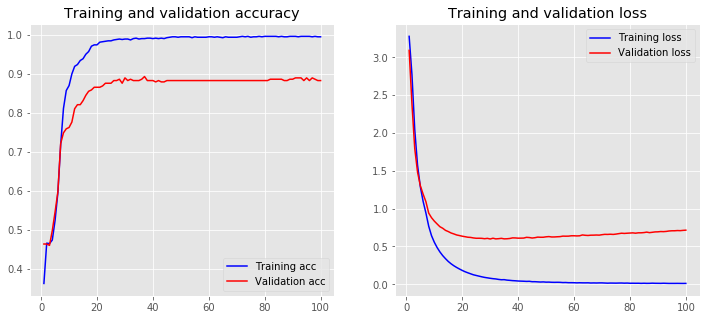

In [37]:
plot_history(history)

### 6. Neural Network with text tokenization

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

In [182]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_train

(375, 100)

In [40]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           67950     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 35)                175035    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1080      
Total params: 244,065
Trainable params: 244,065
Non-trainable params: 0
_________________________________________________________________


Train on 871 samples, validate on 291 samples
Epoch 1/20
871/871 [==============================] - 1s 890us/step - loss: 2.7140 - acc: 0.3077 - val_loss: 2.1968 - val_acc: 0.3024
Epoch 2/20
871/871 [==============================] - 0s 503us/step - loss: 2.0398 - acc: 0.2974 - val_loss: 1.9150 - val_acc: 0.3024
Epoch 3/20
871/871 [==============================] - 0s 495us/step - loss: 1.5657 - acc: 0.3398 - val_loss: 1.5533 - val_acc: 0.4811
Epoch 4/20
871/871 [==============================] - 0s 489us/step - loss: 0.9542 - acc: 0.7049 - val_loss: 1.2543 - val_acc: 0.6667
Epoch 5/20
871/871 [==============================] - 0s 481us/step - loss: 0.4919 - acc: 0.8967 - val_loss: 1.1027 - val_acc: 0.7491
Epoch 6/20
871/871 [==============================] - 0s 498us/step - loss: 0.2562 - acc: 0.9621 - val_loss: 1.1793 - val_acc: 0.7354
Epoch 7/20
871/871 [==============================] - 0s 538us/step - loss: 0.1538 - acc: 0.9770 - val_loss: 1.1176 - val_acc: 0.7595
Epoch 8/20
871/8

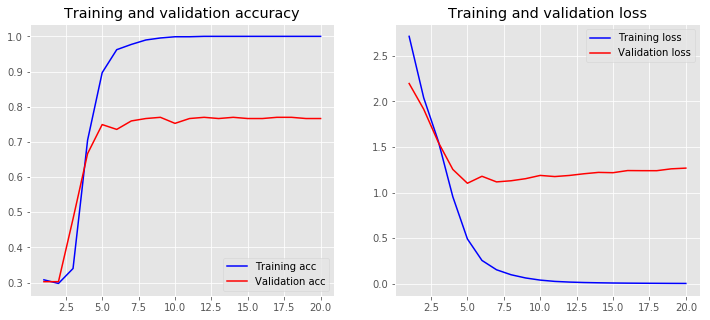

In [41]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [42]:
y_pred = model.predict(X_test)

In [43]:
y_pred = hotdecode(y_pred)

In [44]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [89]:
cm=confusion_matrix(y_test, y_pred)
prec_score = precision_score(y_test, y_pred , average=None)
print(prec_score)

[0.66666667 0.         0.         0.         0.         0.
 1.         0.         1.         0.5        0.66666667 1.
 0.         0.         0.33333333 0.61538462 1.         0.
 0.         0.         0.74358974 0.         0.51724138]


C:\Users\Dolpy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x000001A53D6A13C8>>
Traceback (most recent call last):
  File "C:\Users\Dolpy\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1398, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\Dolpy\Anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 519, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 1808784556104


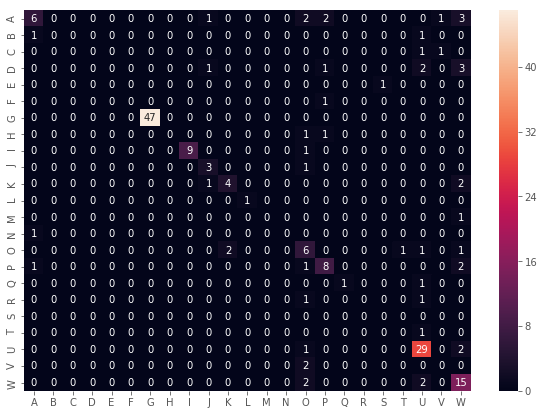

In [90]:
df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJKLMNOPQRSTUVW"],
                  columns = [i for i in "ABCDEFGHIJKLMNOPQRSTUVW"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Dealing with imbalance dataset
## Upsampling minority datapoints

In [91]:
df.label.value_counts()

30    347
28    270
8     151
6      69
20     50
10     42
21     41
1      38
15     28
12     20
4      18
16     12
29     10
22     10
3       9
9       7
26      6
5       6
24      5
2       4
18      3
14      3
17      2
19      2
25      2
7       2
11      2
13      1
23      1
27      1
Name: label, dtype: int64

In [92]:
# Separate majority and minority classes
df_majority = pd.concat([df[df.label==30], df[df.label==28], df[df.label==8], df[df.label==6]])

In [93]:
df_minority = df

In [94]:
df_minority = df_minority[df_minority.label != 30]
df_minority = df_minority[df_minority.label != 28]
df_minority = df_minority[df_minority.label != 8]
df_minority = df_minority[df_minority.label != 6]


In [95]:
list_ = df_minority.label.value_counts().to_dict()

In [96]:
keys = list(list_.keys())

In [185]:
from sklearn.utils import resample
# Upsample minority class
for i in range(len(keys)):
    count = list_[keys[i]]
    if count < 50:
        df_minority_upsampled = resample(df_minority[df_minority.label==keys[i]], 
                                         replace=True,     # sample with replacement
                                         n_samples=50,    # to match majority class
                                         random_state=123) # reproducible results
df_majority = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_majority

Generated Balanced Dataset

In [100]:
print(df_upsampled.label.value_counts())
df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)

30    347
28    270
8     151
13    100
6      69
Name: label, dtype: int64


In [101]:
df_upsampled.head()

,label,keyword
0,28,"tourism,tours,sales,international travel,trave..."
1,30,"english,light,driver,Tour / Travel Management,..."
2,28,"sales,business Development,,Sales / BD,M,I,C,E..."
3,28,"Ticketing,Documentation,Travel,Sales / BD,T,r,..."
4,30,"operations,mice,crm,product,land,outbound,vend..."


Spilting into Training and Testing

In [102]:
x = df_upsampled['keyword'].values
y = df_upsampled['label'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))


vectorizer = CountVectorizer()
vectorizer.fit(x_train)


X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)


y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)


size of x_train (702,), x_test (235,), y_train (702,), y_test (235,)


### 7. Random Forest with Balanced Dataset

In [103]:
forest = RandomForestClassifier(class_weight='balanced')
forest.fit(X_train, y_train)
score = forest.score(X_test, y_test)

print("Accuracy of forest classifier:", round(score,4)*100)

Accuracy of forest classifier: 96.17


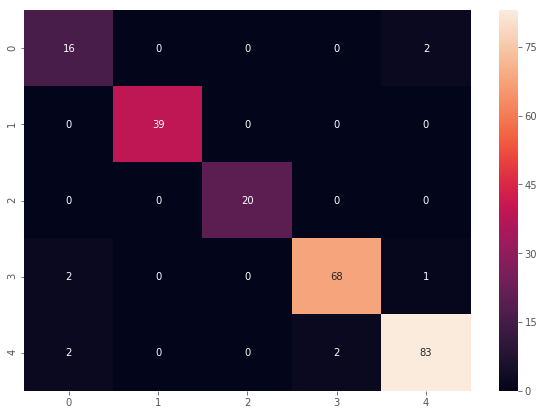

In [104]:
y_pred = forest.predict(X_test)
cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### 8. Neural Network with Balanced dataset and text tokenization

In [105]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)



In [106]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           46300     
_________________________________________________________________
flatten_4 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 35)                175035    
_________________________________________________________________
dense_10 (Dense)             (None, 30)                1080      
Total params: 222,415
Trainable params: 222,415
Non-trainable params: 0
_________________________________________________________________


In [107]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Train on 702 samples, validate on 235 samples
Epoch 1/20
702/702 [==============================] - 1s 1ms/step - loss: 2.2187 - acc: 0.1909 - val_loss: 1.4107 - val_acc: 0.1660
Epoch 2/20
702/702 [==============================] - 0s 527us/step - loss: 1.3227 - acc: 0.1595 - val_loss: 1.3101 - val_acc: 0.1660
Epoch 3/20
702/702 [==============================] - 0s 499us/step - loss: 1.2583 - acc: 0.1595 - val_loss: 1.2208 - val_acc: 0.1660
Epoch 4/20
702/702 [==============================] - 0s 500us/step - loss: 1.1309 - acc: 0.1595 - val_loss: 1.1148 - val_acc: 0.1660
Epoch 5/20
702/702 [==============================] - 0s 531us/step - loss: 1.0415 - acc: 0.1595 - val_loss: 1.0508 - val_acc: 0.1660
Epoch 6/20
702/702 [==============================] - 0s 530us/step - loss: 0.9888 - acc: 0.1595 - val_loss: 1.0444 - val_acc: 0.1660
Epoch 7/20
702/702 [==============================] - 0s 553us/step - loss: 0.9683 - acc: 0.1595 - val_loss: 1.0468 - val_acc: 0.1660
Epoch 8/20
702/702

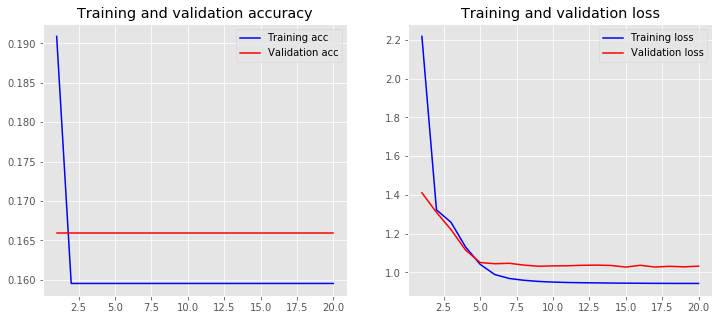

In [108]:
plot_history(history)

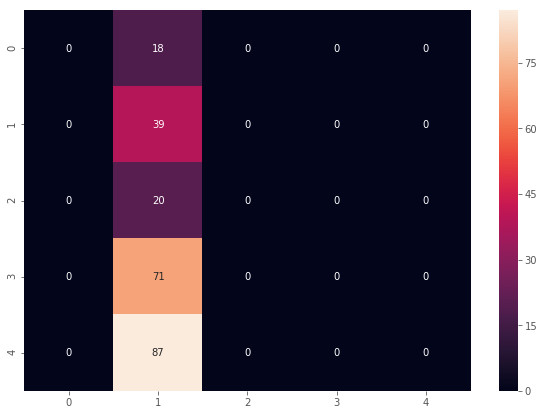

In [109]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Downsampling majority datapoints and upsampling minority datapoints

In [110]:
# Separate majority and minority classes
df_majority = pd.concat([df_upsampled[df_upsampled.label==30], df_upsampled[df_upsampled.label==28], df_upsampled[df_upsampled.label==8], df_upsampled[df_upsampled.label==6]])

df_minority = df_upsampled
df_minority = df_minority[df_minority.label != 30]
df_minority = df_minority[df_minority.label != 28]
df_minority = df_minority[df_minority.label != 8]
df_minority = df_minority[df_minority.label != 6]

In [111]:
df_majority.label.value_counts()

30    347
28    270
8     151
6      69
Name: label, dtype: int64

In [112]:
list_ = df_majority.label.value_counts().to_dict()
keys = list(list_.keys())

In [113]:
keys

[30, 28, 8, 6]

In [114]:
from sklearn.utils import resample
# Upsample minority class
for i in range(len(keys)):
    count = list_[keys[i]]
    if count >100:
        df_majority_downsampled = resample(df_majority[df_majority.label==keys[i]], 
                                         replace=False,     # sample with replacement
                                         n_samples=100,    # to match majority class
                                         random_state=123) # reproducible results
    df_minority = pd.concat([df_minority, df_majority_downsampled])
df_downsampled = df_minority

In [115]:
df_downsampled.label.value_counts()

8     200
30    100
28    100
13    100
Name: label, dtype: int64

In [116]:
x = df_downsampled['keyword'].values
y = df_downsampled['label'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print('size of x_train %s, x_test %s, y_train %s, y_test %s'%(x_train.shape, x_test.shape, y_train.shape, y_test.shape))


vectorizer = CountVectorizer()
vectorizer.fit(x_train)


X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)


y_train_hot = hotencode(y_train)
y_test_hot = hotencode(y_test)


size of x_train (375,), x_test (125,), y_train (375,), y_test (125,)


### 9. Neural Network with Downsampled Majority class and Upsample minority classes

In [117]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = 100


X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           25250     
_________________________________________________________________
flatten_5 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 35)                175035    
_________________________________________________________________
dense_12 (Dense)             (None, 30)                1080      
Total params: 201,365
Trainable params: 201,365
Non-trainable params: 0
_________________________________________________________________


In [118]:
history = model.fit(X_train, y_train_hot,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 375 samples, validate on 125 samples
Epoch 1/20
375/375 [==============================] - 1s 2ms/step - loss: 2.6595 - acc: 0.4693 - val_loss: 1.8358 - val_acc: 0.2000
Epoch 2/20
375/375 [==============================] - 0s 566us/step - loss: 1.4646 - acc: 0.0587 - val_loss: 1.2824 - val_acc: 0.0080
Epoch 3/20
375/375 [==============================] - 0s 556us/step - loss: 1.2376 - acc: 0.2693 - val_loss: 1.1593 - val_acc: 0.4480
Epoch 4/20
375/375 [==============================] - 0s 505us/step - loss: 0.8126 - acc: 0.4640 - val_loss: 0.7306 - val_acc: 0.6320
Epoch 5/20
375/375 [==============================] - 0s 537us/step - loss: 0.3301 - acc: 0.8880 - val_loss: 0.2031 - val_acc: 0.9440
Epoch 6/20
375/375 [==============================] - 0s 577us/step - loss: 0.1059 - acc: 0.9787 - val_loss: 0.1325 - val_acc: 0.9360
Epoch 7/20
375/375 [==============================] - 0s 604us/step - loss: 0.0381 - acc: 1.0000 - val_loss: 0.0839 - val_acc: 1.0000
Epoch 8/20
375/375

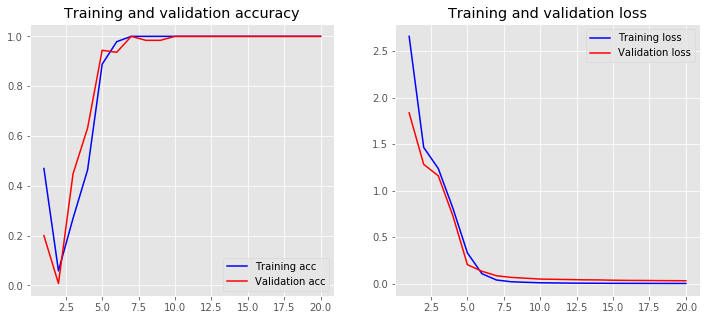

In [119]:
plot_history(history)

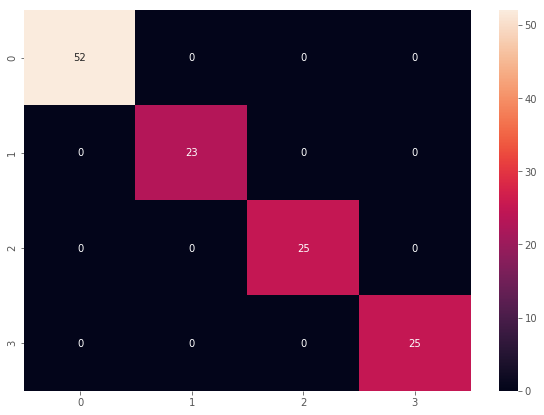

In [120]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Introducing Word Embedding from Glove
Using pre-trained weights

In [144]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath , encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [146]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B.50d.txt',
     tokenizer.word_index, embedding_dim)

In [147]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Ratio of nonzero elements in embedding matrix : %s'%(nonzero_elements / vocab_size), 'This means %s of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.'%(nonzero_elements*100 / vocab_size))


Ratio of nonzero elements in embedding matrix : 0.9524752475247524 This means 95.24752475247524 of the vocabulary is covered by the pretrained model, which is a good coverage of our vocabulary.


### 10. Neural Network without training of embedding matrix 
Glove word vector is used directly without any training

In [148]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_hot,
                    epochs=200,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           25250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 35)                1785      
_________________________________________________________________
dense_14 (Dense)             (None, 30)                1080      
Total params: 28,115
Trainable params: 2,865
Non-trainable params: 25,250
_________________________________________________________________
Train on 375 samples, validate on 125 samples
Epoch 1/200
375/375 [==============================] - 1s 2ms/step - loss: 2.9812 - acc: 0.1307 - val_loss: 2.3159 - val_acc: 0.2480
Epoch 2/200
375/375 [==============================] - 0s 207us/step - loss: 1.8499 - a

Epoch 114/200
375/375 [==============================] - 0s 223us/step - loss: 0.0984 - acc: 0.9733 - val_loss: 0.1301 - val_acc: 0.9360
Epoch 115/200
375/375 [==============================] - 0s 229us/step - loss: 0.0950 - acc: 0.9627 - val_loss: 0.1283 - val_acc: 0.9280
Epoch 116/200
375/375 [==============================] - 0s 197us/step - loss: 0.0926 - acc: 0.9653 - val_loss: 0.1484 - val_acc: 0.9440
Epoch 117/200
375/375 [==============================] - 0s 197us/step - loss: 0.0946 - acc: 0.9707 - val_loss: 0.1303 - val_acc: 0.9360
Epoch 118/200
375/375 [==============================] - 0s 210us/step - loss: 0.0917 - acc: 0.9653 - val_loss: 0.1391 - val_acc: 0.9360
Epoch 119/200
375/375 [==============================] - 0s 210us/step - loss: 0.0955 - acc: 0.9627 - val_loss: 0.1264 - val_acc: 0.9360
Epoch 120/200
375/375 [==============================] - 0s 202us/step - loss: 0.0938 - acc: 0.9680 - val_loss: 0.1297 - val_acc: 0.9360
Epoch 121/200
375/375 [==================

In [150]:
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9787
Testing Accuracy:  0.9440


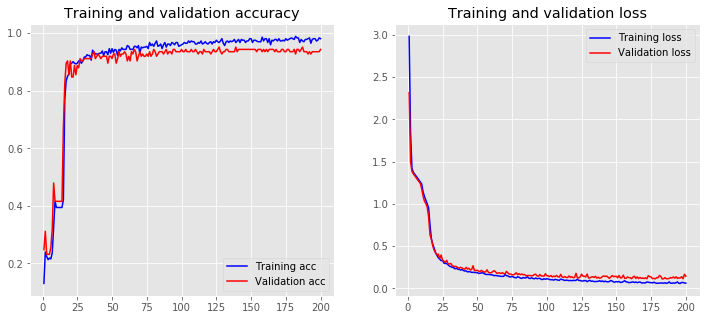

In [151]:
plot_history(history)


### 11. Neural Network with training of embedding matrix
Glove word vector is used with retraining with respect to currecnt dataset 

In [152]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(35, activation='relu'))
model.add(layers.Dense(30, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_hot,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test_hot),
                    batch_size=10)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           25250     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 35)                1785      
_________________________________________________________________
dense_16 (Dense)             (None, 30)                1080      
Total params: 28,115
Trainable params: 28,115
Non-trainable params: 0
_________________________________________________________________
Train on 375 samples, validate on 125 samples
Epoch 1/50
375/375 [==============================] - 1s 2ms/step - loss: 2.8800 - acc: 0.0000e+00 - val_loss: 2.4048 - val_acc: 0.0000e+00
Epoch 2/50
375/375 [==============================] - 0s 426us/step - loss: 2.0689 -

Training Accuracy: 1.0000
Testing Accuracy:  0.9920


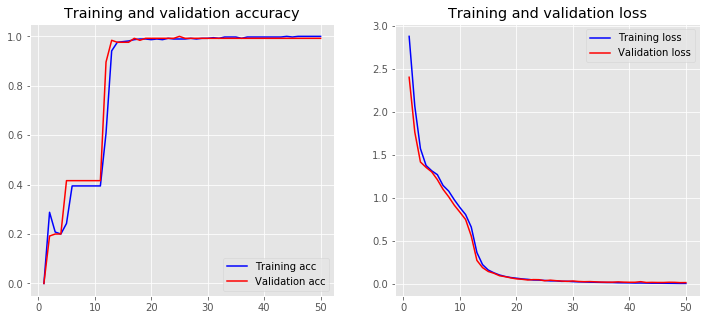

In [153]:
loss, accuracy = model.evaluate(X_train, y_train_hot, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_hot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

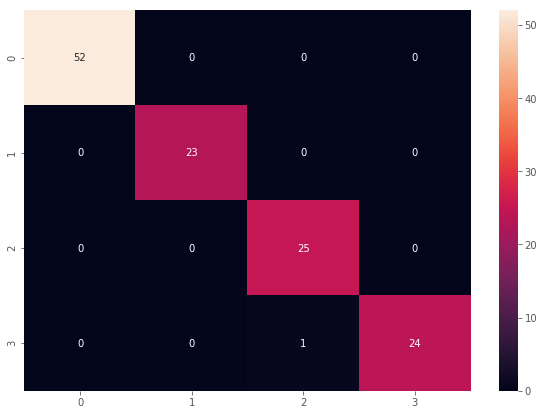

In [154]:
y_pred = model.predict(X_test)
y_pred = hotdecode(y_pred)

cm=confusion_matrix(y_test, y_pred)

index = columns = [i for i in range(len(cm))]
df_cm = pd.DataFrame(cm, index = index,
                  columns = columns)

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

**Results Summary:**
_Provide a brief summary of results obtained like model accuracy & other insights based on EDA & your interpretations_

1. UnBalanced dataset may give wrong accuracy parameters as shown in section 1 to secton 6. By analyzing confusion matrix, it was clear that low frequency data is neglected and our algorithm is predicting most majority of class.
2. UnBalanced dataset need to Balanced first before doing any kind of analysis. Confusion matrix is a good matric to check the real accuracy of the algorithm
3. Linear classifier like Decision perform OK in this dataset but there is lot of scope of improvements
4. Neural Network started from pre-trained weight but not re-training is taking a much greater time in achieving similar accuracy as for re-training weights methodology
5. Neural Network started from pre-trained weight perform best in this case and obtained an accuracy of 97.18 in testing and confusion matrix is show at 273 line